<a href="https://colab.research.google.com/github/PsorTheDoctor/microarray-data/blob/main/utils/load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Przygotowanie danych mikromacierzowych

In [4]:
!git clone https://github.com/PsorTheDoctor/microarray-data.git
%cd microarray-data/

Cloning into 'microarray-data'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 89 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.
/content/microarray-data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_data(path='/content/microarray-data/data/'):
  """
  Funkcja działa analogicznie do load_data zbioru MNIST.
  Zwraca (X_train, y_train), (X_test, y_test) o wymiarach:
  (900, 20, 50)
  (900,)
  (157, 20, 50)
  (157,)
  Dla potrzeb wizualizacji każdy gen przyjmuje wymiary prostokąta 20 x 50.
  """
  microarrays = []

  # Załadowanie danych
  for filename in os.listdir(path):
    full_path = os.path.join(path, filename)

    if os.path.isfile(full_path):
      if filename[-5:] == '.arff':
        microarray, _ = arff.loadarff(full_path)
        microarrays.append(microarray)

  # Konkatenacja danych z plików do jednej listy o długości 1057
  data = [*microarrays[0], *microarrays[1], *microarrays[2], *microarrays[3],
          *microarrays[4], *microarrays[5], *microarrays[6], *microarrays[7]]

  # 1057 pacjentów
  patients = len(data)
  # 1000 genów i 1 etykieta na pacjenta
  genes = len(data[0]) - 1

  # Zamiana listy data na macierze numpy
  X_flatten = np.zeros((patients, genes))
  X_reshaped = np.zeros((patients, 20, 50))
  y = np.zeros(patients)

  for i in range(patients):
    for j in range(genes):
      X_flatten[i][j] = data[i][j]

    # Normalizacja w przedziale <0, 1> w obrębie pojedynczego genu
    df = pd.DataFrame(X_flatten[i])
    x = df.select_dtypes(include=[np.number])
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_norm = scaler.fit_transform(x)

    # Zmiana kształtu genu na 20 x 50
    X_reshaped[i] = np.reshape(x_norm, (20, 50))

    # Zastąpienie etykiet wartościami logicznymi
    if str(data[i][1000]) == "b'yes'":
      y[i] = 1
    elif str(data[i][1000]) == "b'no'":
      y[i] = 0

  # Przetasowanie elementów
  indices = np.arange(1057)
  X_shuffled = tf.gather(X_reshaped, indices)
  y_shuffled = tf.gather(y, indices)

  # Podział na zbiór treningowy i testowy
  X_train = X_shuffled[:900]
  X_test = X_shuffled[-157:]
  y_train = y_shuffled[:900]
  y_test = y_shuffled[-157:]

  return (X_train, y_train), (X_test, y_test)

In [5]:
(X_train, y_train), (X_test, y_test) = load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(900, 20, 50)
(157, 20, 50)
(900,)
(157,)


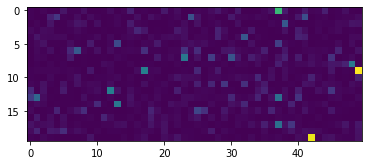

In [7]:
plt.imshow(X_train[0], cmap='viridis')

In [11]:
# Do użycia podczas trenowania GANów i sieci niewymagających etykiet
def load_data_by_label(label):
  """
  Zwraca (X_train, X_test) o wymiarach:
  (n, 20, 50)
  (n, 20, 50)
  Gdzie n jest liczbą przypadków oznaczonych daną etykietą.
  """
  (X_train, y_train), (X_test, y_test) = load_data()

  assert X_train.shape[0] == y_train.shape[0]
  assert X_test.shape[0] == y_test.shape[0]
  assert label == 0 or label == 1

  X_pos_train = []
  for i in range(X_train.shape[0]):
    if y_train[i] == label:
      X_pos_train.append(X_train[i])

  X_pos_test = []
  for i in range(X_test.shape[0]):
    if y_test[i] == label:
      X_pos_test.append(X_test[i])

  X_pos_train = np.array(X_pos_train)
  X_pos_test = np.array(X_pos_test)

  return X_pos_train, X_pos_test

In [13]:
# Przypadki pozytywne
(X_pos_train, X_pos_test) = load_data_by_label(label=1)

print(X_pos_train.shape)
print(X_pos_test.shape)

(400, 20, 50)
(71, 20, 50)


In [14]:
# Przypadki negatywne
(X_neg_train, X_neg_test) = load_data_by_label(label=0)

print(X_neg_train.shape)
print(X_neg_test.shape)

(500, 20, 50)
(86, 20, 50)
